<a href="https://colab.research.google.com/github/manitprats/Time-Series-Forecasting/blob/main/LSTM_Covid_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
country = "US"
#country = 'India'

In [ ]:
#Total COVID confirmed cases
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")


In [ ]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [ ]:
df_confirmed_country = df_confirmed[df_confirmed["Country/Region"] == country]
df_confirmed_country

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
260,NaN,US,40.0,-100.0,1,1,2,2,5,5,...,103443455,103533872,103589757,103648690,103650837,103646975,103655539,103690910,103755771,103802702


In [ ]:
df_confirmed_country = pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(),columns=["confirmed"])
df_confirmed_country.head()

,confirmed
1/22/20,1
1/23/20,1
1/24/20,2
1/25/20,2
1/26/20,5


In [ ]:
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')
df_confirmed_country.head()

,confirmed
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5


<Axes: title={'center': 'COVID confirmed cases'}>

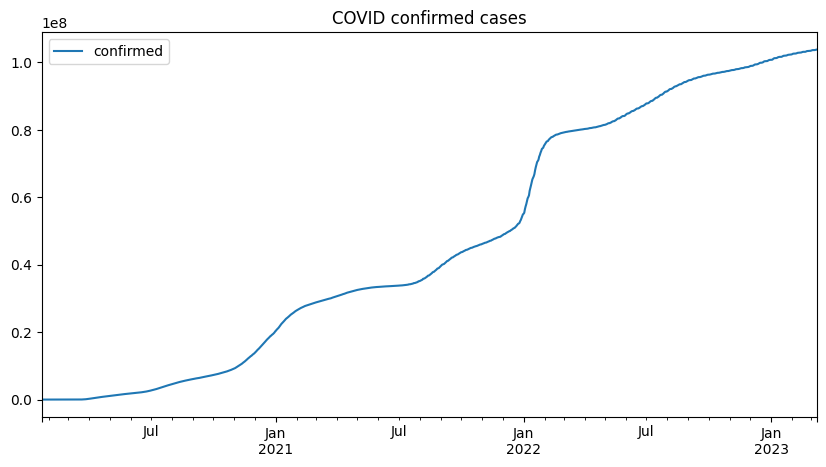

In [ ]:
df_confirmed_country.plot(figsize=(10,5),title="COVID confirmed cases")


In [ ]:
df_confirmed_country.tail(10)

,confirmed
2023-02-28,103443455
2023-03-01,103533872
2023-03-02,103589757
2023-03-03,103648690
2023-03-04,103650837
2023-03-05,103646975
2023-03-06,103655539
2023-03-07,103690910
2023-03-08,103755771
2023-03-09,103802702


In [ ]:
print("Total days in the dataset", len(df_confirmed_country))


Total days in the dataset 1143


In [ ]:
#Use data until 14 days before as training
x = len(df_confirmed_country)-14

train=df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]


In [ ]:
train

,confirmed
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
...,...
2023-02-19,103136077
2023-02-20,103138119
2023-02-21,103198669
2023-02-22,103308832


In [ ]:
##scale or normalize data as the data is too skewed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)


In [ ]:
## Use TimeSeriestrain_generator to generate data in sequences.
#Alternatively we can create our own sequences. 
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
#Sequence size has an impact on prediction, especially since COVID is unpredictable!
seq_size = 7  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 1129
print("Total number of samples in the generated data = ", len(train_generator)) # 1122 with seq_size=7

Total number of samples in the original training data =  1129
Total number of samples in the generated data =  1122


In [ ]:
#Check data shape from generator
x,y = train_generator[10]  #Check train_generator
#Takes 7 days as x and 8th day as y (for seq_size=7)

In [ ]:
#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7
#Check data shape from generator
x,y = test_generator[0]

Total number of samples in the original training data =  14
Total number of samples in the generated data =  7


In [ ]:
print(x.shape)
print(y.shape)

(1, 7, 1)
(1, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

In [ ]:
#Define Model 
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')
##########################


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 7, 150)            91200     
                                                                 
 lstm_32 (LSTM)              (None, 64)                55040     
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=100, steps_per_epoch=10)

Epoch 1/100


<ipython-input-262-e74d4582180e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


10/10 [==============================] - 7s 149ms/step - loss: 0.1866 - val_loss: 0.4568
Epoch 2/100
10/10 [==============================] - 1s 52ms/step - loss: 0.0609 - val_loss: 3.7687e-04
Epoch 3/100
10/10 [==============================] - 0s 34ms/step - loss: 0.0151 - val_loss: 0.0309
Epoch 4/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0175 - val_loss: 0.0028
Epoch 5/100
10/10 [==============================] - 0s 42ms/step - loss: 0.0033 - val_loss: 6.2631e-04
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0016 - val_loss: 5.9911e-05
Epoch 7/100
10/10 [==============================] - 0s 29ms/step - loss: 1.8268e-04 - val_loss: 1.0247e-05
Epoch 8/100
10/10 [==============================] - 0s 29ms/step - loss: 7.5065e-04 - val_loss: 5.6997e-04
Epoch 9/100
10/10 [==============================] - 0s 36ms/step - loss: 1.8231e-04 - val_loss: 2.1514e-04
Epoch 10/100
10/10 [==============================] - 0s 25ms/step - loss: 

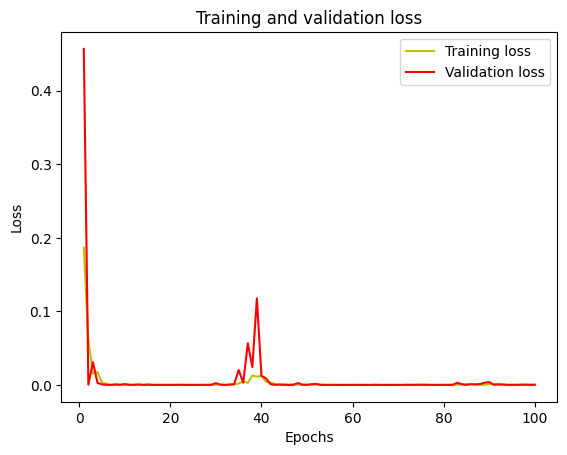

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape


In [ ]:
## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 32ms/step


In [ ]:
### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

In [ ]:
time_series_array = test.index  #Get dates for test data


In [ ]:
#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]


<ipython-input-268-f1f25296e141>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
<ipython-input-268-f1f25296e141>:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]


<Axes: title={'center': 'Predictions for next 7 days'}>

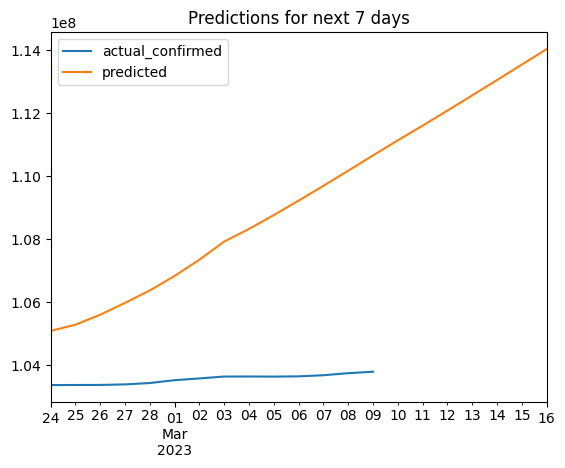

In [ ]:
#Plot
df_forecast.plot(title="Predictions for next 7 days")